Seed set to 42


 NOTE: 1302 lesions shared between TRAIN and VAL (image-level validation)

Per-class report (image-level):
              precision    recall  f1-score   support

          NV      0.721     0.673     0.697       946
         MEL      0.568     0.613     0.590       705
         SCC      0.274     0.356     0.310        73
         BKL      0.324     0.317     0.320       287
         BCC      0.688     0.680     0.684       649
          AK      0.357     0.399     0.377       138
          DF      0.556     0.200     0.294        25

    accuracy                          0.598      2823
   macro avg      0.498     0.462     0.467      2823
weighted avg      0.604     0.598     0.599      2823

Image-level balanced accuracy: 0.4624889560458278

Per-class report (lesion-level):
              precision    recall  f1-score   support

          NV      0.724     0.743     0.734       339
         MEL      0.483     0.588     0.530       165
         SCC      0.250     0.423     0.314      

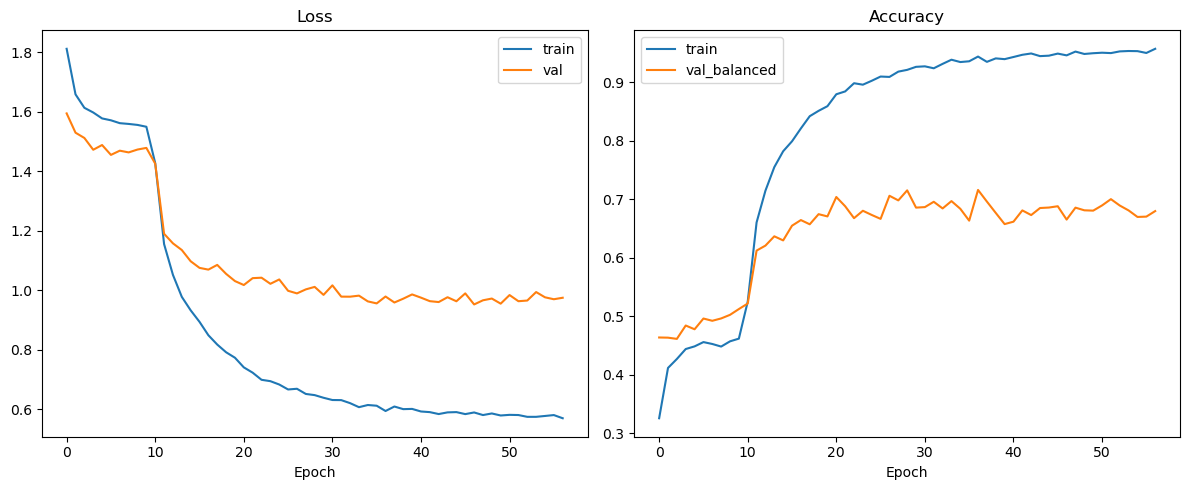

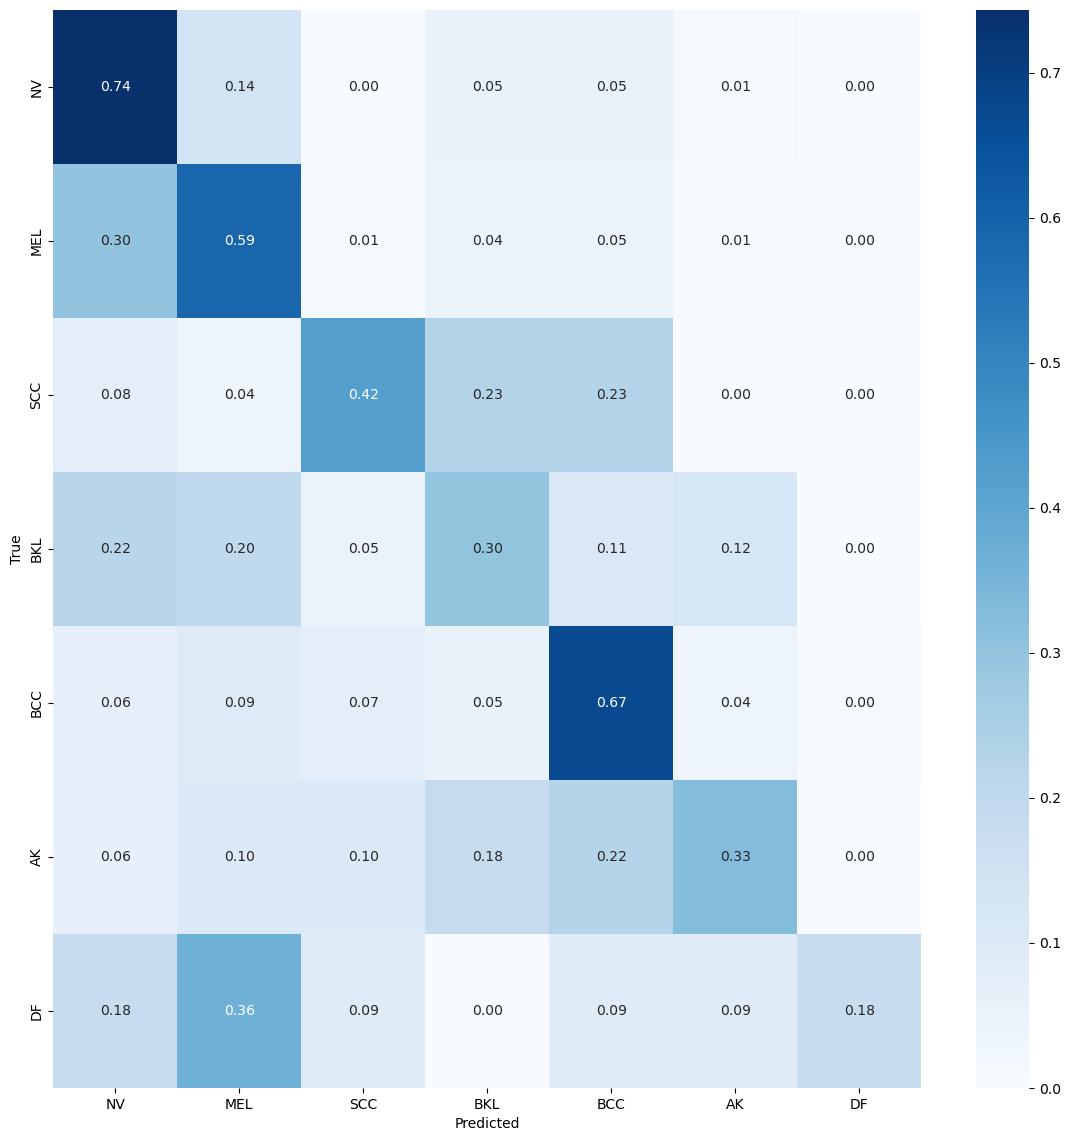

In [1]:
from pathlib import Path
import pytorch_lightning as pl
import torch

import pandas as pd
import numpy as np
from sklearn.metrics import balanced_accuracy_score

from config import *
from data.splits import create_splits, create_splits_from_file, create_lesion_kfold_splits, create_lesion_1_img
from data.transforms import get_transforms
from data.datamodule import ImageDataModule
from models.efficientnet import EfficientNetLit
from utils.plots import plot_metrics, plot_confusion_matrix
from utils.seed import set_seed
from sklearn.metrics import classification_report
from utils.make_sampler import make_sampler


def main():
    set_seed(SEED)

    fold = 2  # <<< МЕНЯЕШЬ ФОЛД ЗДЕСЬ

    LOG_DIR = Path(f"logs/efficientnet/clean_data_{fold}")
    CKPT_DIR = LOG_DIR / "checkpoints"
    CKPT_PATH = next(CKPT_DIR.glob("best*.ckpt"))

    #train_df, val_df, test_df, classes = create_splits_from_file(
    #    split_csv=SPLIT_FILE,
    #    images_dir=DATA_DIR,
    #    fold=fold,
    #)

    #classes_map = dict(zip(train_df['label'], train_df['diagnosis']))
    #classes = [classes_map[i] for i in sorted(classes_map.keys())]

    train_df, val_df, test_df, classes = create_lesion_kfold_splits(
        metadata_csv=METADATA_DIR,
        images_dir=DATA_DIR,
        seed=SEED,
        test_size=TEST_SIZE,
        val_size=VAL_SIZE,
        n_folds=N_FOLDS,
        fold=fold,
    )

    train_sampler = make_sampler(train_df["label"].values)

    train_tfms, val_tfms = get_transforms()

    datamodule = ImageDataModule(
        train_df,
        val_df,
        test_df,
        train_tfms,
        val_tfms,
        BATCH_SIZE,
        NUM_WORKERS,
        train_sampler,
    )

    model = EfficientNetLit.load_from_checkpoint(
        CKPT_PATH,
        num_classes=len(classes),
        lr=LR,
        weight_decay=WEIGHT_DECAY,
        dropout=DROPOUT,
        strict=True,
    )

    model.eval()
    preds, targets = [], []

    datamodule.setup(stage="test")

    for x, y in datamodule.test_dataloader():
        x, y = x.to(model.device), y.to(model.device)
        with torch.no_grad():
            logits = model(x)
            pred = logits.argmax(1)

        preds.extend(pred.cpu().numpy())
        targets.extend(y.cpu().numpy())

    # -------------------------
    # IMAGE-LEVEL → LESION-LEVEL
    # -------------------------
    image_bal_acc = balanced_accuracy_score(targets, preds)

    print("\nPer-class report (image-level):")
    print(
        classification_report(
            targets,
            preds,
            target_names=classes,
            digits=3,
            zero_division=0,
        )
    )

    print("Image-level balanced accuracy:", image_bal_acc)

    
    df = test_df.copy().reset_index(drop=True)
    df["pred"] = preds

    lesion_preds = (
        df.groupby("lesion_id")["pred"]
        .agg(lambda x: np.bincount(x).argmax())
    )

    lesion_targets = (
        df.groupby("lesion_id")["label"].first()
    )

    print("\nPer-class report (lesion-level):")
    print(
        classification_report(
            lesion_targets,
            lesion_preds,
            target_names=classes,
            digits=3,
            zero_division=0,
        )
    )

    bal_acc = balanced_accuracy_score(lesion_targets, lesion_preds)
    print("Lesion-level balanced accuracy:", bal_acc)

    OUTPUT_DIR = LOG_DIR / "figures"
    OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

    
    
    #plot_metrics(LOG_DIR, save_path=OUTPUT_DIR / "metrics.pdf")
    plot_confusion_matrix(lesion_targets, lesion_preds, classes, save_path=OUTPUT_DIR / "confusion_matrix.pdf")
    

if __name__ == "__main__":
    main()


Seed set to 42


 NOTE: 700 lesions shared between TRAIN and VAL (image-level validation)
 NOTE: 734 lesions shared between TRAIN and VAL (image-level validation)
 NOTE: 731 lesions shared between TRAIN and VAL (image-level validation)
 NOTE: 735 lesions shared between TRAIN and VAL (image-level validation)
 NOTE: 728 lesions shared between TRAIN and VAL (image-level validation)


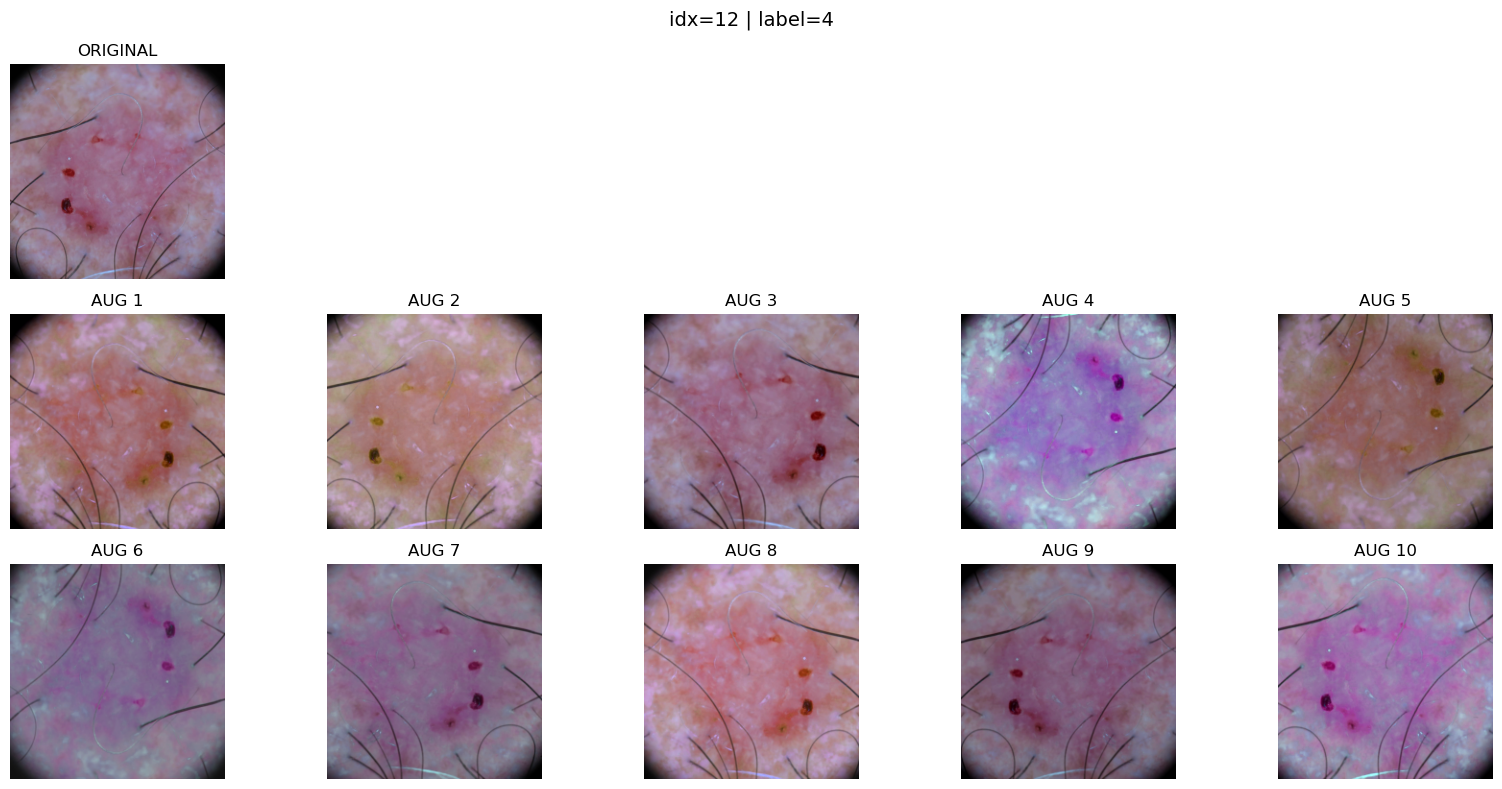

In [3]:
# classifier/inspect_transforms.py

import os
import torch
import matplotlib.pyplot as plt
from PIL import Image

from config import *
from data.splits import create_splits_from_file
from data.transforms import get_transforms
from utils.seed import set_seed


def denormalize(img, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img * std + mean


def find_image_path(row, images_dir):
    """
    Находит изображение по bcn_filename / isic_id
    """
    exts = ["", ".jpg", ".png", ".jpeg"]

    # 1. Явно берём имя файла
    candidates = []

    if "bcn_filename" in row:
        candidates.append(row["bcn_filename"])

    if "isic_id" in row:
        candidates.append(row["isic_id"])

    # 2. Пробуем разные варианты путей
    for name in candidates:
        for ext in exts:
            fname = name if name.endswith(ext) else name + ext

            paths = [
                os.path.join(images_dir, fname),
                os.path.join(images_dir, "images", fname),
                os.path.join(images_dir, "ISIC_Images", fname),
            ]

            for p in paths:
                if os.path.isfile(p):
                    return p

    raise FileNotFoundError(
        f"Не удалось найти файл изображения.\n"
        f"bcn_filename={row.get('bcn_filename')}\n"
        f"isic_id={row.get('isic_id')}\n"
        f"images_dir={images_dir}"
    )




def main():
    set_seed(SEED)

    for fold in range(1, 6):
        train_df, val_df, test_df, classes = create_splits_from_file(
            split_csv=SPLIT_FILE,
            images_dir=METADATA_DIR,
            fold=fold,
        )

    train_tfms, _ = get_transforms()

    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]

    # выбираем конкретный индекс
    idx = 12         
    row = train_df.iloc[idx]

    img_path = find_image_path(row, METADATA_DIR)
    label = row["label"]

    img_pil = Image.open(img_path).convert("RGB")

    # ---------- ВИЗУАЛИЗАЦИЯ ----------
    plt.figure(figsize=(16, 8))

    # ОРИГИНАЛ
    plt.subplot(3, 5, 1)
    plt.imshow(img_pil)
    plt.title("ORIGINAL")
    plt.axis("off")

    #  АУГМЕНТАЦИИ
    for i in range(10):
        img = train_tfms(img_pil)
        img = denormalize(img, mean, std)
        img = img.permute(1, 2, 0).clamp(0, 1)

        plt.subplot(3, 5, i + 6)
        plt.imshow(img)
        plt.title(f"AUG {i+1}")
        plt.axis("off")

    plt.suptitle(
        f"idx={idx} | label={classes[label]}",
        fontsize=14
    )
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [2]:
import pandas as pd

# Пути к файлам
ORIG_METADATA_PATH = "/home/project/experiment/BCN20000/bcn20000_metadata.csv"
SPLIT_PATH = "/home/project/experiment/BCN20000/master_split_file_3.csv"

# --- 1. Загружаем данные ---
orig_df = pd.read_csv(ORIG_METADATA_PATH)
split_df = pd.read_csv(SPLIT_PATH)

# --- 2. Приводим ключи к одному виду ---
# из bcn_filename -> isic_id (убираем .jpg)
split_df["isic_id"] = split_df["bcn_filename"].str.replace(".jpg", "", regex=False)

# --- 3. Берём только нужные колонки ---
orig_sub = orig_df[["isic_id", "diagnosis_3"]]
split_sub = split_df[["isic_id", "diagnosis"]]

# --- 4. Мёрджим ---
merged = orig_sub.merge(split_sub, on="isic_id", how="inner")

# --- 5. Убираем пустые диагнозы (опционально, но полезно) ---
merged = merged.dropna(subset=["diagnosis_3", "diagnosis"])

# --- 6. Смотрим соответствие ---
mapping = (
    merged[["diagnosis_3", "diagnosis"]]
    .drop_duplicates()
    .sort_values(["diagnosis", "diagnosis_3"])
    .reset_index(drop=True)
)

print("\n=== diagnosis_3 → diagnosis ===\n")
print(mapping)

# --- 7. (Бонус) То же самое, но в виде сводной таблицы ---
print("\n=== Crosstab ===\n")
print(pd.crosstab(merged["diagnosis_3"], merged["diagnosis"]))



=== diagnosis_3 → diagnosis ===

                    diagnosis_3 diagnosis
0    Solar or actinic keratosis        AK
1          Basal cell carcinoma       BCC
2          Seborrheic keratosis       BKL
3                 Solar lentigo       BKL
4                Dermatofibroma        DF
5           Melanoma metastasis       MEL
6                 Melanoma, NOS       MEL
7                         Nevus        NV
8  Squamous cell carcinoma, NOS       SCC

=== Crosstab ===

diagnosis                       AK    BCC   BKL   DF    MEL     NV   SCC
diagnosis_3                                                             
Basal cell carcinoma             0  18380     0    0      0      0     0
Dermatofibroma                   0      0     0  840      0      0     0
Melanoma metastasis              0      0     0    0   3165      0     0
Melanoma, NOS                    0      0     0    0  20015      0     0
Nevus                            0      0     0    0      0  28235     0
Seborrheic kerat

In [46]:
import pandas as pd
SPLIT_PATH = "/home/project/experiment/BCN20000/master_split_file_2.csv"


df = pd.read_csv(SPLIT_PATH)

dup_ids = (
    df["lesion_id"]
    .value_counts()
    .loc[lambda x: x > 1]
    .index
)

print(f"repeated lesion_id: {len(dup_ids)}")

sample_ids = dup_ids[:15]

duplicates_df = df[df["lesion_id"].isin(sample_ids)] \
    .sort_values(["lesion_id", "fold_number", "split_type"])

print(duplicates_df)


repeated lesion_id: 4933
           bcn_filename  age_approx anatom_site_general diagnosis   lesion_id  \
31     ISIC_0053489.jpg        75.0     upper extremity       MEL  IL_0087971   
359    ISIC_0053853.jpg        75.0     upper extremity       MEL  IL_0087971   
457    ISIC_0053969.jpg        75.0     upper extremity       MEL  IL_0087971   
1172   ISIC_0054795.jpg        75.0     upper extremity       MEL  IL_0087971   
1805   ISIC_0055517.jpg        75.0     upper extremity       MEL  IL_0087971   
...                 ...         ...                 ...       ...         ...   
81997  ISIC_0067947.jpg        50.0      anterior torso       MEL  IL_9808031   
83655  ISIC_0069821.jpg        50.0      anterior torso       MEL  IL_9808031   
85074  ISIC_0071471.jpg        50.0      anterior torso       MEL  IL_9808031   
80823  ISIC_0066627.jpg        50.0      anterior torso       MEL  IL_9808031   
81663  ISIC_0067577.jpg        50.0      anterior torso       MEL  IL_9808031   

  

In [51]:
import pandas as pd

SPLIT_PATH = "/home/project/experiment/BCN20000/master_split_file_2.csv"
df = pd.read_csv(SPLIT_PATH)

# оставим только train/val (если вдруг есть test)
df = df[df["split_type"].isin(["train", "validation"])]

# для каждого lesion_id и fold смотрим какие split_type там встречаются
leak_pairs = (
    df.groupby(["fold_number", "lesion_id"])["split_type"]
      .nunique()
      .reset_index(name="n_splits")
)

# утечки = где split_type и train и val => значит уникальных split_type = 2
leaks = leak_pairs[leak_pairs["n_splits"] == 2]

print(f"Train/Val leakage cases: {len(leaks)} (fold, lesion_id pairs)")

# покажем примеры
sample = leaks.head(15)

leak_df = (
    df.merge(sample[["fold_number", "lesion_id"]], on=["fold_number", "lesion_id"])
      .sort_values(["fold_number", "lesion_id", "split_type"])
)

print(leak_df)


Train/Val leakage cases: 3628 (fold, lesion_id pairs)
        bcn_filename  age_approx anatom_site_general diagnosis   lesion_id  \
88  ISIC_0072988.jpg        70.0           head/neck       BCC  IL_0027947   
32  ISIC_0060682.jpg        70.0           head/neck       BCC  IL_0027947   
23  ISIC_0058722.jpg        85.0           head/neck       BCC  IL_0076164   
85  ISIC_0072605.jpg        85.0           head/neck       BCC  IL_0076164   
43  ISIC_0064431.jpg        85.0           head/neck       BCC  IL_0076164   
..               ...         ...                 ...       ...         ...   
82  ISIC_0072037.jpg        75.0      anterior torso       BCC  IL_0275242   
55  ISIC_0067064.jpg        75.0      anterior torso       BCC  IL_0275242   
28  ISIC_0059968.jpg        45.0     upper extremity        NV  IL_0277423   
68  ISIC_0068865.jpg        45.0     upper extremity        NV  IL_0277423   
22  ISIC_0058148.jpg        45.0     upper extremity        NV  IL_0277423   

       se

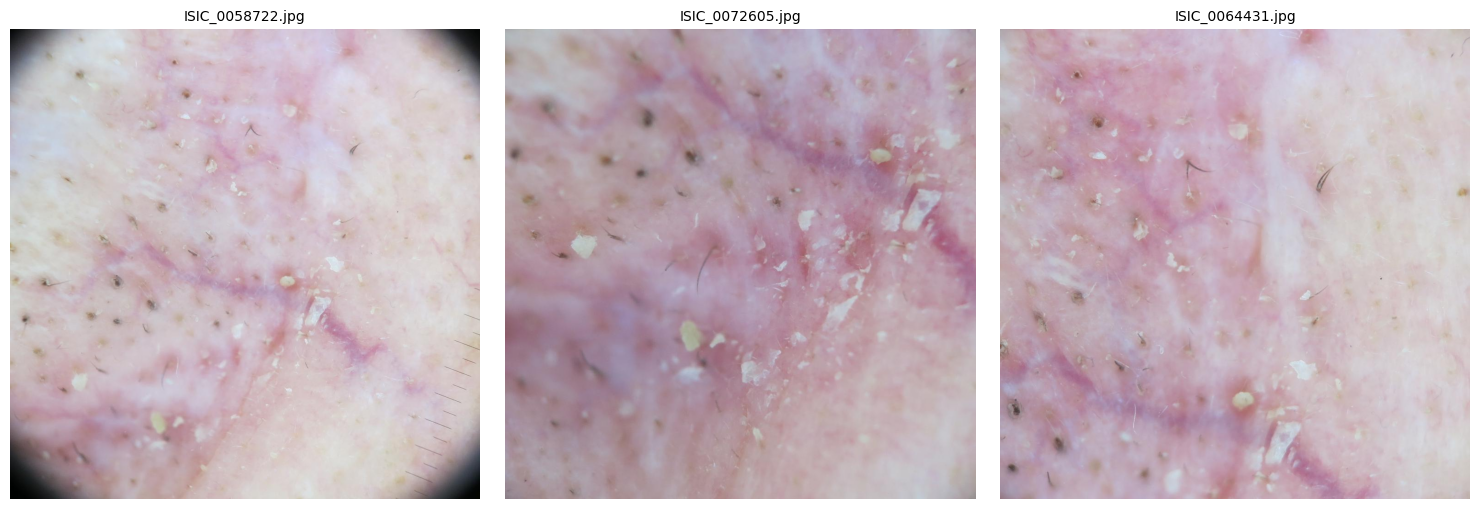

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

IMAGES_DIR = Path("/home/project/datasets/BCN_pure/")

files_to_show = [
   
    "ISIC_0059968.jpg",
    "ISIC_0068865.jpg",
    "ISIC_0058148.jpg",
    

]

n = len(files_to_show)
plt.figure(figsize=(5 * n, 5))

for i, fname in enumerate(files_to_show):
    img_path = IMAGES_DIR / fname

    if not img_path.exists():
        print(f"Файл не найден: {img_path}")
        continue

    img = Image.open(img_path).convert("RGB")

    plt.subplot(1, n, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(fname, fontsize=10)

plt.tight_layout()
plt.savefig("duplicats_NV_tr_tr_val.pdf", format="pdf", bbox_inches="tight")
plt.show()


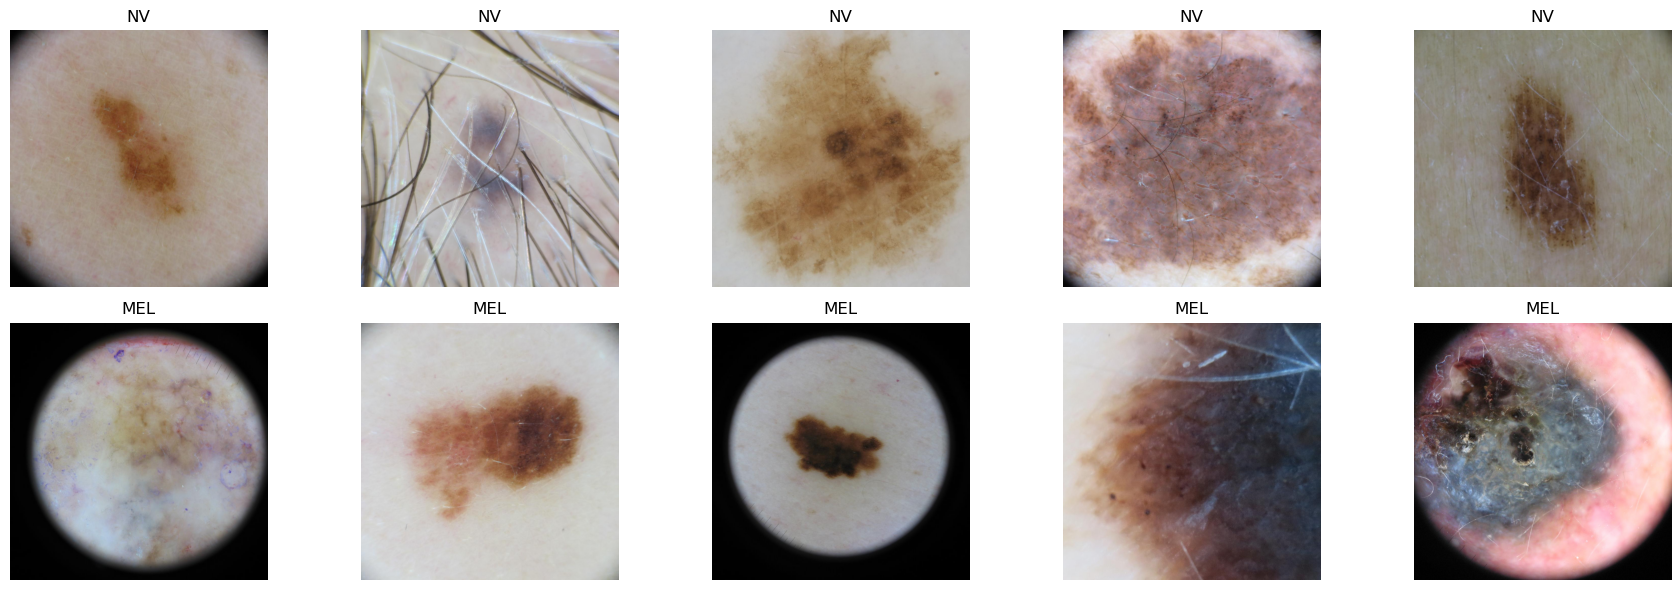

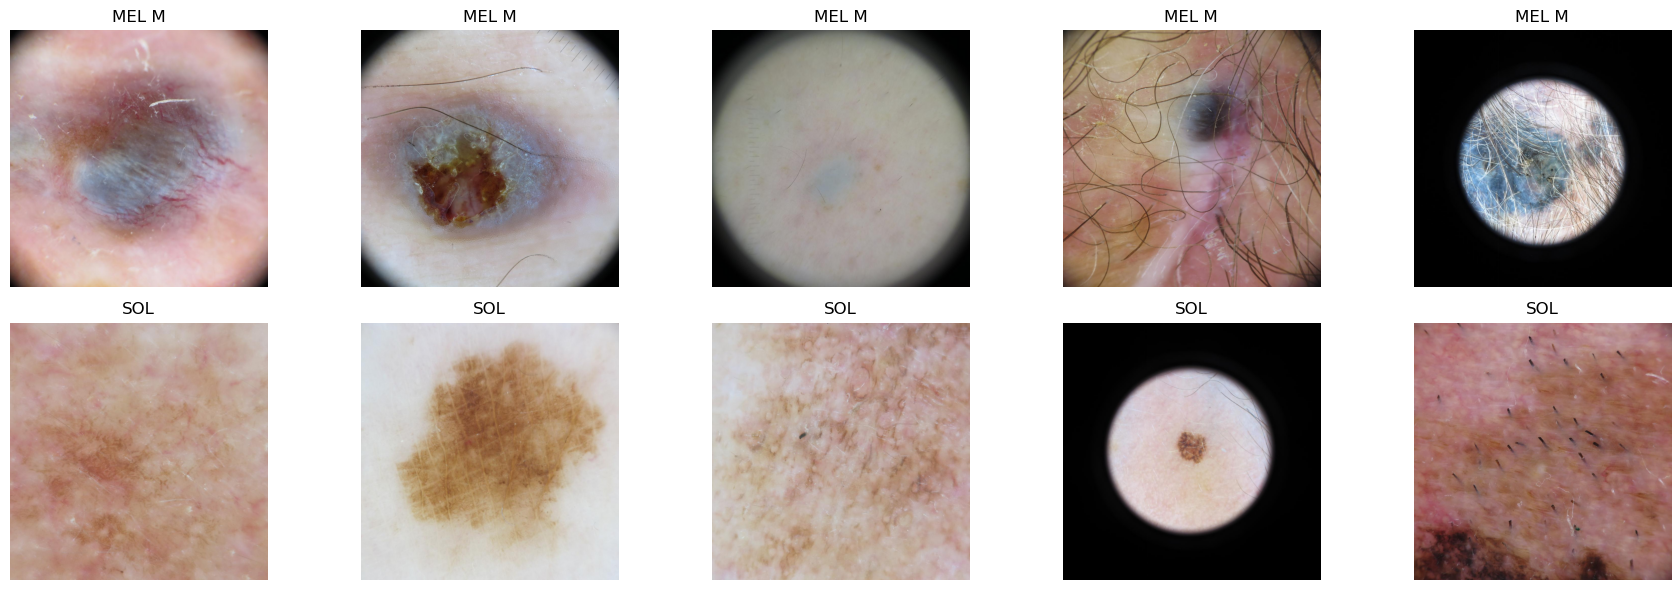

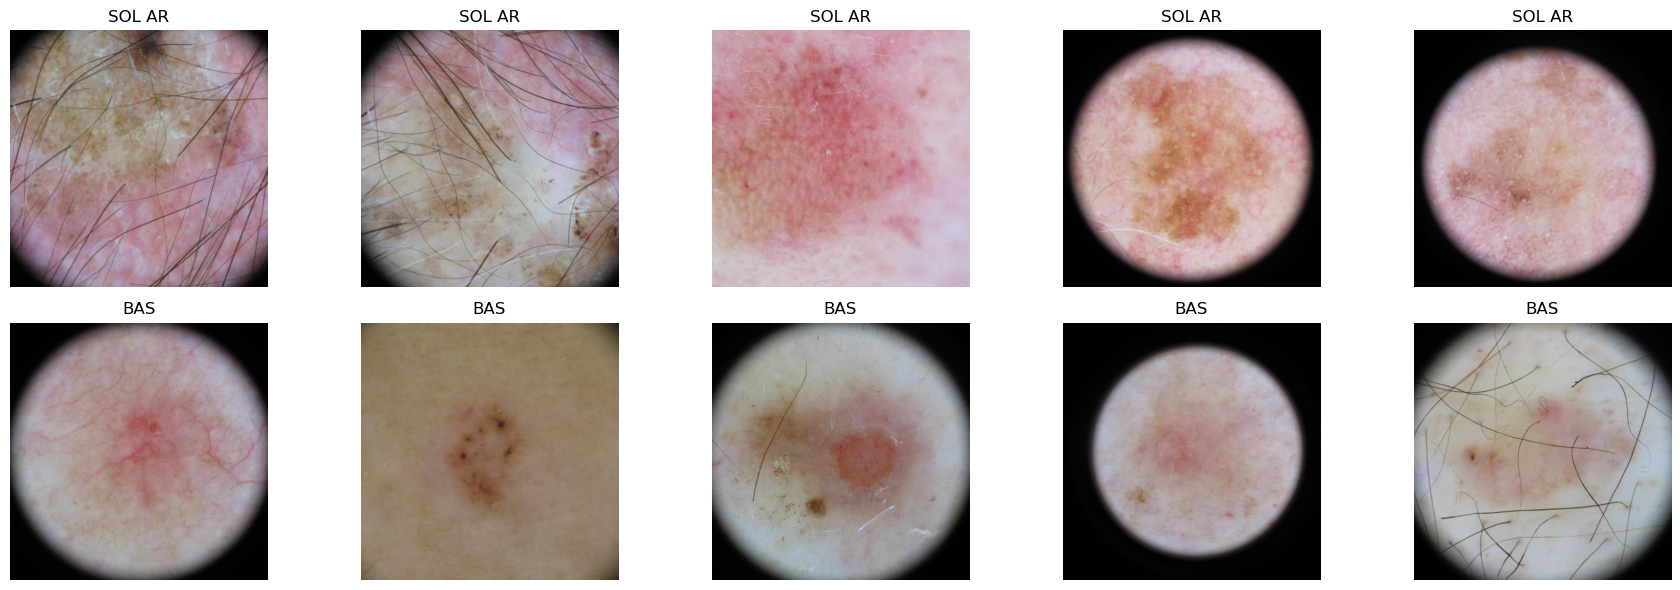

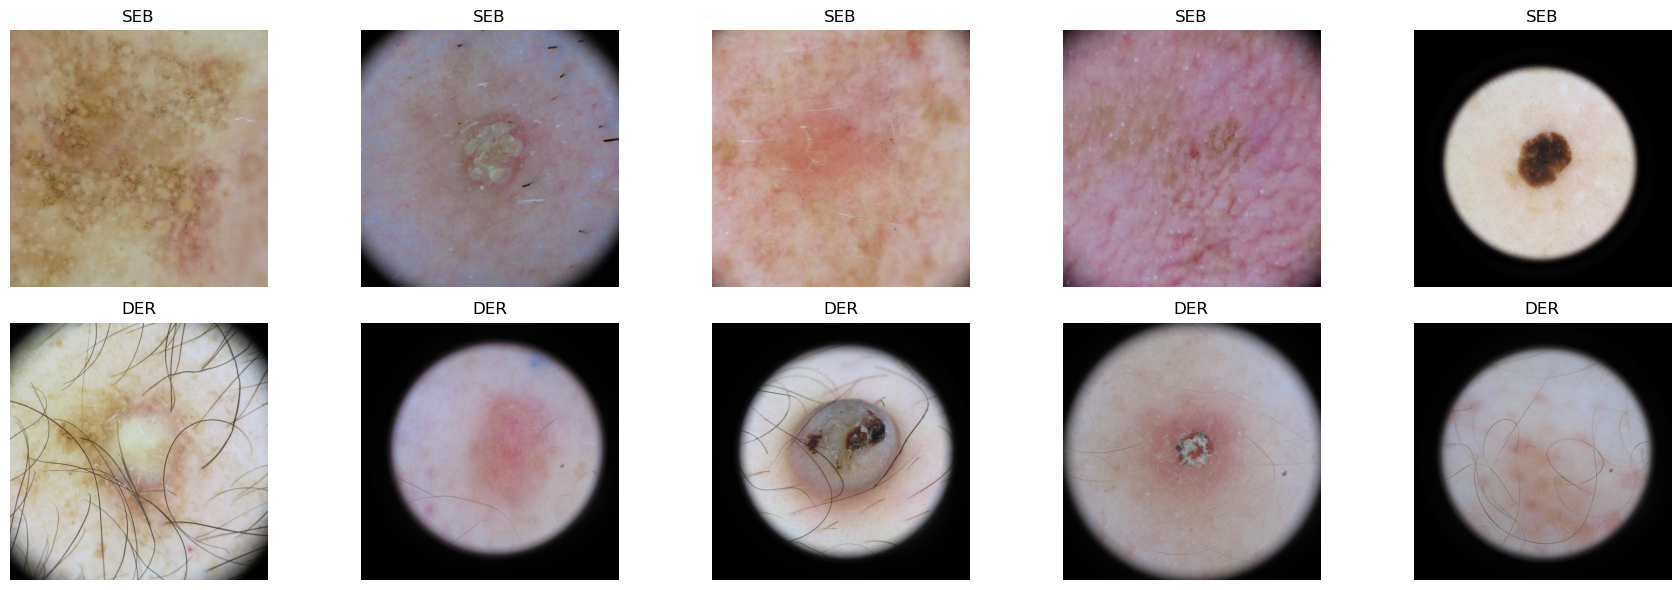

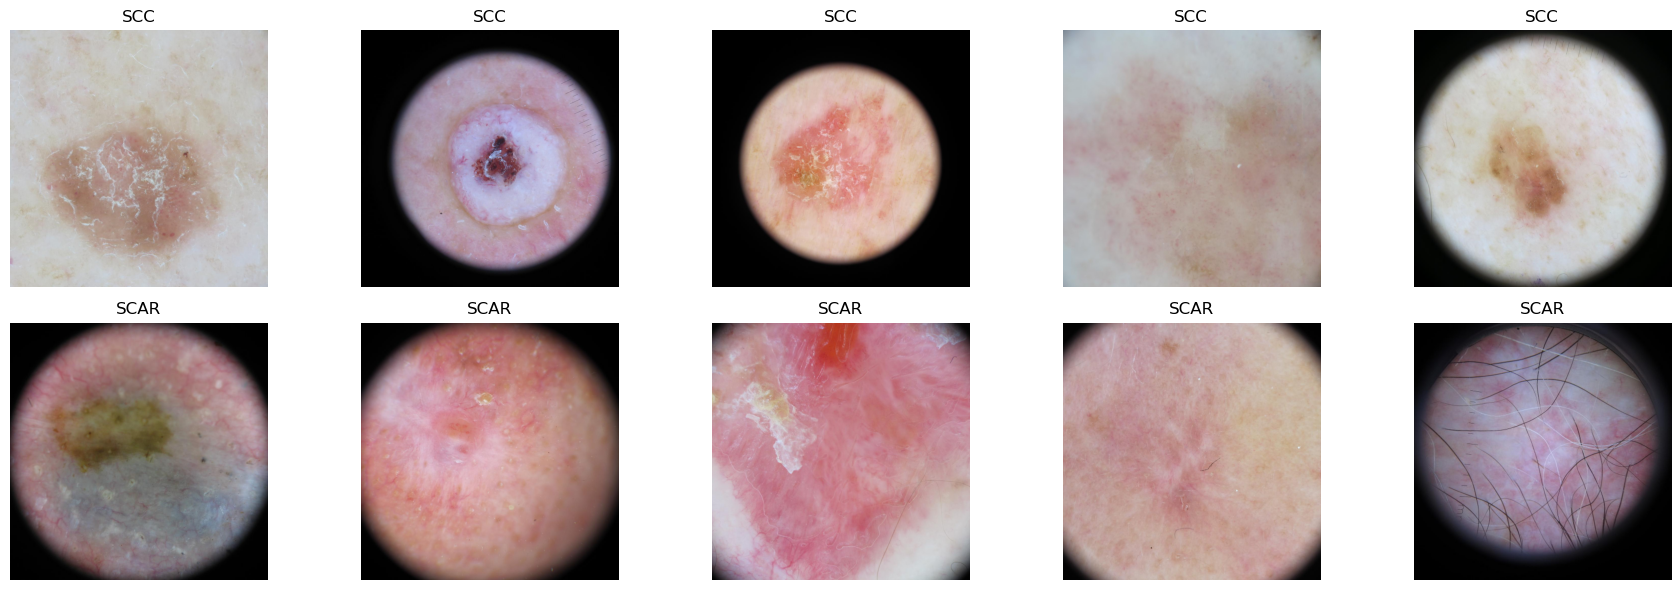

In [2]:
# This script loads the metadata, applies the same split logic,
# samples 7 NV images and 7 MEL images from the TEST split,
# and displays them with MEL shown under NV.

import random
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

METADATA_DIR = Path("/home/project/datasets/BCN_pure/")
IMAGES_DIR = Path("/home/project/datasets/BCN_pure/")

# Load metadata
df = pd.read_csv(METADATA_DIR / "metadata.csv")

# Diagnosis map (must match training)
DIAGNOSIS_MAP = {
    "Solar or actinic keratosis": "AK",
    "Basal cell carcinoma": "BCC",
    "Seborrheic keratosis": "BKL",
    "Solar lentigo": "BKL",
    "Dermatofibroma": "DF",
    "Melanoma metastasis": "MEL",
    "Melanoma, NOS": "MEL",
    "Nevus": "NV",
    "Squamous cell carcinoma, NOS": "SCC",
    "Scar": "SCAR",
}

df = df[df["diagnosis_3"].isin(DIAGNOSIS_MAP)].copy()
df["diagnosis"] = df["diagnosis_3"].map(DIAGNOSIS_MAP)
df["path"] = df["isic_id"].apply(lambda x: IMAGES_DIR / f"{x}.jpg")

# Filter classes
nv_df = df[df["diagnosis_3"] == "Nevus"].sample(5, random_state=26)
mel_df = df[df["diagnosis_3"] == "Melanoma, NOS"].sample(5, random_state=25)
melm_df = df[df["diagnosis_3"] == "Melanoma metastasis"].sample(5, random_state=1)
sol_len_df = df[df["diagnosis_3"] == "Solar lentigo"].sample(5, random_state=56)
sol_ar_df = df[df["diagnosis_3"] == "Solar or actinic keratosis"].sample(5, random_state=72)
bas_df = df[df["diagnosis_3"] == "Basal cell carcinoma"].sample(5, random_state=98)
seb_df = df[df["diagnosis_3"] == "Seborrheic keratosis"].sample(5, random_state=36)
der_df = df[df["diagnosis_3"] == "Dermatofibroma"].sample(5, random_state=48)
squ_df = df[df["diagnosis_3"] == "Squamous cell carcinoma, NOS"].sample(5, random_state=223)
sca_df = df[df["diagnosis_3"] == "Scar"].sample(5, random_state=72)

# Plot
fig, axes = plt.subplots(2, 5, figsize=(18, 6))

for i, row in enumerate(nv_df.itertuples()):
    img = Image.open(row.path).convert("RGB")
    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    axes[0, i].set_title("NV")

for i, row in enumerate(mel_df.itertuples()):
    img = Image.open(row.path).convert("RGB")
    axes[1, i].imshow(img)
    axes[1, i].axis("off")
    axes[1, i].set_title("MEL")

plt.tight_layout()
plt.savefig("sample1.svg", format="svg", bbox_inches="tight")
plt.show()

# Plot
fig, axes = plt.subplots(2, 5, figsize=(18, 6))

for i, row in enumerate(melm_df.itertuples()):
    img = Image.open(row.path).convert("RGB")
    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    axes[0, i].set_title("MEL M")

for i, row in enumerate(sol_len_df.itertuples()):
    img = Image.open(row.path).convert("RGB")
    axes[1, i].imshow(img)
    axes[1, i].axis("off")
    axes[1, i].set_title("SOL")

plt.tight_layout()
plt.savefig("sample2.svg", format="svg", bbox_inches="tight")
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(18, 6))

for i, row in enumerate(sol_ar_df.itertuples()):
    img = Image.open(row.path).convert("RGB")
    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    axes[0, i].set_title("SOL AR")

for i, row in enumerate(bas_df.itertuples()):
    img = Image.open(row.path).convert("RGB")
    axes[1, i].imshow(img)
    axes[1, i].axis("off")
    axes[1, i].set_title("BAS")

plt.tight_layout()
plt.savefig("sample3.svg", format="svg", bbox_inches="tight")
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(18, 6))

for i, row in enumerate(seb_df.itertuples()):
    img = Image.open(row.path).convert("RGB")
    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    axes[0, i].set_title("SEB")

for i, row in enumerate(der_df.itertuples()):
    img = Image.open(row.path).convert("RGB")
    axes[1, i].imshow(img)
    axes[1, i].axis("off")
    axes[1, i].set_title("DER")

plt.tight_layout()
plt.savefig("sample4.svg", format="svg", bbox_inches="tight")
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(18, 6))

for i, row in enumerate(squ_df.itertuples()):
    img = Image.open(row.path).convert("RGB")
    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    axes[0, i].set_title("SCC")

for i, row in enumerate(sca_df.itertuples()):
    img = Image.open(row.path).convert("RGB")
    axes[1, i].imshow(img)
    axes[1, i].axis("off")
    axes[1, i].set_title("SCAR")

plt.tight_layout()
plt.savefig("sample5.svg", format="svg", bbox_inches="tight")
plt.show()
